# Modification of the original code
I just took the code of the winner of the RSNA 2022 cervical spine fracture detection competition.  
Link: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1

# 1st Place Solution Training 3D Semantic Segmentation (Stage1)

Hi all,

I'm very exciting to writing this notebook and the summary of our solution here.

This is FULL version of training my final models (stage1), using resnet18d as backbone, unet as decoder and using 128x128x128 as input.

NOTE: **You need to run this code locally because the RAM is not enough here.**

NOTE2: **It is highly recommended to pre-process the 3D semantic segmentation training data first and save it locally, which can greatly speed up the loading of the data.**

My brief summary of winning solution: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/362607

* Train Stage1 Notebook: This notebook
* Train Stage2 (Type1) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type1
* Train Stage2 (Type2) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type2
* Inference Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-inference

**If you find these notebooks helpful please upvote. Thanks! **

In [1]:
#!pip -q install monai
#!pip -q install segmentation-models-pytorch==0.2.1

In [2]:
DEBUG = False

import os
import sys
#sys.path = [
#    '../input/covn3d-same',
#] + sys.path

In [3]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import dicomsdl
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import gzip
import pickle
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from timm.utils import AverageMeter

import sklearn.metrics

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

sys.path.append('./lib_models')

# Config

In [4]:
RESOL = 128

BASE_PATH = '/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'
SAVE_DIR_PATH = f'{BASE_PATH}/class_models'
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-7
batch_size = 32
drop_rate = 0.2
drop_path_rate = 0.2
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '../input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 8
out_dim = 5

n_epochs = 1000



log_dir = f'{SAVE_DIR_PATH}/logs'
model_dir = f'{SAVE_DIR_PATH}/models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

# Data split

In [6]:
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_meta = pd.read_csv(f'{BASE_PATH}/train_series_meta.csv')
train_df = train_df.sort_values(by=['patient_id'])
train_df

TRAIN_PATH = BASE_PATH + "/train_images"
n_chunk = 8
patients = os.listdir(TRAIN_PATH)
n_patients = len(patients)
rng_patients = np.linspace(0, n_patients+1, n_chunk+1, dtype = int)
patients_cts = glob(f'{TRAIN_PATH}/*/*')
n_cts = len(patients_cts)
patients_cts_arr = np.zeros((n_cts, 2), int)
data_paths=[]
for i in range(0, n_cts):
    patient, ct = patients_cts[i].split('/')[-2:]
    patients_cts_arr[i] = patient, ct
    data_paths.append(f'{BASE_PATH}/3d_preprocessed/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.pkl')
TRAIN_IMG_PATH = BASE_PATH + '/processed' 

#Generate tables for training
train_meta_df = pd.DataFrame(patients_cts_arr, columns = ['patient_id', 'series'])

#5-fold splitting
train_df['fold'] = 0
labels = train_df[['bowel_healthy','bowel_injury',
                    'extravasation_healthy','extravasation_injury',
                    'kidney_healthy','kidney_low','kidney_high',
                    'liver_healthy','liver_low','liver_high',
                    'spleen_healthy','spleen_low','spleen_high',
                    'any_injury']].to_numpy()

mskf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
counter = 0
for train_index, test_index in mskf.split(np.ones(len(train_df)), labels):
    for i in range(0, len(test_index)):
        train_df['fold'][test_index[i]] = counter
    counter+=1

train_meta_df = train_meta_df.join(train_df.set_index('patient_id'), on='patient_id')
train_meta_df['path']=data_paths
train_meta_df.to_csv(f'{BASE_PATH}/train_meta.csv', index = False)
np.unique(train_meta_df['fold'].to_numpy(), return_counts = True)
train_meta_df

,patient_id,series,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,fold,path
0,43082,25988,1,0,1,0,1,0,0,0,1,0,1,0,0,1,3,/home/junseonglee/01_codes/input/rsna-2023-abd...
1,29731,30872,1,0,1,0,1,0,0,1,0,0,1,0,0,0,4,/home/junseonglee/01_codes/input/rsna-2023-abd...
2,65083,64311,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,/home/junseonglee/01_codes/input/rsna-2023-abd...
3,65083,32240,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,/home/junseonglee/01_codes/input/rsna-2023-abd...
4,9860,2625,1,0,1,0,1,0,0,1,0,0,1,0,0,0,3,/home/junseonglee/01_codes/input/rsna-2023-abd...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,9703,39470,1,0,1,0,1,0,0,0,0,1,0,1,0,1,3,/home/junseonglee/01_codes/input/rsna-2023-abd...
4707,9703,29219,1,0,1,0,1,0,0,0,0,1,0,1,0,1,3,/home/junseonglee/01_codes/input/rsna-2023-abd...
4708,52564,21130,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,/home/junseonglee/01_codes/input/rsna-2023-abd...
4709,4093,5176,0,1,0,1,1,0,0,0,1,0,0,0,1,1,4,/home/junseonglee/01_codes/input/rsna-2023-abd...


# Dataset

In [7]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)


def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

def load_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data    

def load_sample(row, has_mask=True):
    image = decompress(row['img_path'])[None]        
    return image

In [8]:
# Read each slice and stack them to make 3d data
def process_3d(save_path, data_path = TRAIN_PATH):
    tmp = save_path.split('/')[-1][:-4]
    tmp = tmp.split('_')
    patient, study = int(tmp[0]), int(tmp[1])
    imgs = {}    
    
    for f in sorted(glob(data_path + f'/{patient}/{study}/*.dcm')):      
        pixel_rep = 0
        bit_shift = 0
        dtype = 0
        try:
            dicom = pydicom.dcmread(f)        
            img, pixel_rep, bit_shift, dtype = standardize_pixel_array(dicom)
            img = img.astype(float)
            break
        except:
            continue
            
    for f in sorted(glob(data_path + f'/{patient}/{study}/*.dcm')):
        #For the case that some of the image can't be read -> error without this though don't know why  
        img = dicomsdl.open(f).pixelData(storedvalue=True).astype(float)
        #dicom = pydicom.dcmread(f)
        #img = standardize_pixel_array(dicom).astype(float)
        #ind = int((f.split('/')[-1])[:-4])
        pos_z = -int((f.split('/')[-1])[:-4])
        imgs[pos_z] = img


    sample_z = np.linspace(0, len(imgs)-1, RESOL, dtype=int)

    imgs_3d = []
    for i, k in enumerate(sorted(imgs.keys())):
        if i in sample_z:
            img = imgs[k]
            imgs_3d.append(cv2.resize(img, (RESOL, RESOL))[None])
    
    imgs_3d = np.vstack(imgs_3d)
    
    
    nu = np.zeros((RESOL, RESOL, RESOL))

    for i in range(0, len(imgs_3d[0,0])):
        nu[:,:,i] = cv2.resize(imgs_3d[:,:,i], (RESOL, RESOL))
    imgs_3d  = nu            

    # To deal with random image edge    

    imgs_3d = ((imgs_3d - imgs_3d.min()) / (imgs_3d.max() - imgs_3d.min()))

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        imgs_3d = 1.0 - imgs_3d
    
    #Samplewise standardization to deal with the variety of the test datset.
    std = np.std(imgs_3d)
    avg = np.average(imgs_3d)
    imgs_3d = (imgs_3d-avg)/std
    imgs_3d = imgs_3d.astype(np.float32)

    #here to
    compress(save_path, imgs_3d)                      

    del imgs, img, nu
    gc.collect()

    return imgs_3d

In [9]:
class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]                
        label = row[['bowel_healthy','bowel_injury',
                    'extravasation_healthy','extravasation_injury',
                    'kidney_healthy','kidney_low','kidney_high',
                    'liver_healthy','liver_low','liver_high',
                    'spleen_healthy','spleen_low','spleen_high', 'any_injury']]

        try:
            data_3d = decompress(row['path'])
        except:
            data_3d = process_3d(row['path'])           

        data_3d = data_3d.reshape(1, RESOL, RESOL, RESOL).astype(np.float32)  # channel, 3D 
        data_3d = torch.from_numpy(data_3d)
    
        label = label.to_numpy().astype(np.float32)
                
        label = torch.from_numpy(label)
        return data_3d, label        

# Model

In [10]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )
        self.flatten = nn.Flatten()
        
        # Head part        
        size_res_out = 299520        
        self.fc_bowel = nn.Linear(size_res_out, 2)
        self.fc_extrav= nn.Linear(size_res_out, 2)
        self.fc_kidney= nn.Linear(size_res_out, 3)
        self.fc_liver = nn.Linear(size_res_out, 3)
        self.fc_spleen= nn.Linear(size_res_out, 3)
        
        self.maxpool  = nn.MaxPool1d(5, 1)
        self.softmax  = nn.Softmax(dim=1)

    def forward(self,x):
        global_features = self.encoder(x)[:n_blocks]
        pooled_features = []
        for i in range(0, len(global_features)):        
            pooled_features.append(self.flatten(torch.sum(global_features[i], dim = 1)))

        pooled_features = torch.cat(pooled_features, dim = 1)
        bowel  = self.fc_bowel(pooled_features)
        extrav = self.fc_extrav(pooled_features)
        kidney = self.fc_kidney(pooled_features)
        liver  = self.fc_liver(pooled_features)
        spleen = self.fc_spleen(pooled_features)
        
        labels = torch.cat([bowel, extrav, kidney, liver, spleen], dim = 1)

        bowel_soft = self.softmax(bowel)
        extrav_soft = self.softmax(extrav)
        kidney_soft = self.softmax(kidney)
        liver_soft = self.softmax(liver)
        spleen_soft = self.softmax(spleen)

        any_in = torch.cat([1-bowel_soft[:,0:1], 1-extrav_soft[:,0:1], 
                            1-kidney_soft[:,0:1], 1-liver_soft[:,0:1], 1-spleen_soft[:,0:1]], dim = 1) 
        any_in = self.maxpool(any_in)
        any_not_in = 1-any_in
        any_in = torch.cat([any_not_in, any_in], dim = 1)

        labels = torch.cat([labels, any_in], dim = 1)
        return labels
        #seg_features = self.decoder(*global_features)
        #seg_features = self.segmentation_head(seg_features)


In [11]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
out = m(torch.rand(1, 1, 128,128,128))
for i in range(0, len(out)):
    print(out[i].shape)

torch.Size([15])


In [12]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(m))
gc.collect()

43614957


168

# Loss & Metric

In [13]:
from typing import Any, Dict, Optional

weights = np.ones(2)
weights[1]  = 2
crit_bowel  = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))
weights[1]  = 6
crit_extrav = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))
crit_any    = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))

weights = np.ones((3))
weights[1]  = 2
weights[2]  = 4
crit_kidney = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))
crit_liver  = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))
crit_spleen = nn.CrossEntropyLoss(weight = torch.from_numpy(weights).to(device))

def apply_loss(pred, truth):
    batch_size = pred.shape[0]
    loss  = crit_bowel(pred[:,:2], truth[:,:2])
    loss += crit_extrav(pred[:,2:4], truth[:,2:4])
    loss += crit_kidney(pred[:,4:7], truth[:,4:7])
    loss += crit_liver(pred[:,7:10], truth[:,7:10])
    loss += crit_spleen(pred[:,10:13], truth[:,10:13])

    loss += crit_any(pred[:,13:15],  torch.cat([torch.ones(batch_size, 1).to(device)- truth[:,13:14],truth[:,13:14]], dim = 1))  
    loss /= 6
    return loss


In [14]:
def apply_softmax_to_labels(X_out):
    softmax = nn.Softmax(dim=1)

    X_out[:,:2]    = normalize_to_one(softmax(X_out[:,:2]))
    X_out[:,2:4]   = normalize_to_one(softmax(X_out[:,2:4]))
    X_out[:,4:7]   = normalize_to_one(softmax(X_out[:,4:7]))
    X_out[:,7:10]  = normalize_to_one(softmax(X_out[:,7:10]))
    X_out[:,10:13] = normalize_to_one(softmax(X_out[:,10:13]))

    return X_out


def postprocess_preds_labels(preds, labels):
    batch_size = preds.shape[0]
    preds = apply_softmax_to_labels(preds).detach().to('cpu').numpy()    
    labels = labels.to('cpu')
    labels_any = labels[:,-1:]
    labels     = labels[:,:-1]
    labels_any = torch.cat([torch.ones(batch_size, 1)- labels_any,labels_any], dim = 1)    
    labels_any = labels_any.numpy()
    labels     = np.hstack([labels, labels_any])                
    return preds, labels


def normalize_to_one(tensor):
    norm = torch.sum(tensor, 1)
    for i in range(0, tensor.shape[1]):
        tensor[:,i]/=norm
    return tensor


def calculate_score(X_outs, ys):
    bowel_weights =  ys[:,0] + 2*ys[:,1]
    extrav_weights = ys[:,2] + 6*ys[:,3]
    kidney_weights = ys[:,4] + 2*ys[:,5] + 4*ys[:,6]
    liver_weights  = ys[:,7] + 2*ys[:,8] + 4*ys[:,9]
    spleen_weights = ys[:,10] + 2*ys[:,11] + 4*ys[:,12]
    any_in_weights = ys[:,13] + 6*ys[:,14]

    loss = (
             sklearn.metrics.log_loss(ys[:,:2], X_outs[:,:2], sample_weight = bowel_weights)
           + sklearn.metrics.log_loss(ys[:,2:4], X_outs[:,2:4], sample_weight = extrav_weights)
           + sklearn.metrics.log_loss(ys[:,4:7], X_outs[:,4:7], sample_weight = kidney_weights)
           + sklearn.metrics.log_loss(ys[:,7:10], X_outs[:,7:10], sample_weight = liver_weights)
           + sklearn.metrics.log_loss(ys[:,10:13], X_outs[:,10:13], sample_weight = spleen_weights)
           + sklearn.metrics.log_loss(ys[:,13:15], X_outs[:,13:15], sample_weight =  any_in_weights)
           ) / 6
    return loss

# Train & Valid func

In [15]:
def mixup(inputs, truth, clip=[0, 1]):
    indices = torch.randperm(inputs.size(0))
    shuffled_input = inputs[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    inputs = inputs * lam + shuffled_input * (1 - lam)
    return inputs, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    train_meters = {'loss': AverageMeter()}
    model.train()
    train_loss   = []
    total_preds  = []
    total_labels = []
    bar = tqdm(loader_train)
    for images, labels in bar:
        optimizer.zero_grad()
        images = images.cuda()
        labels = labels.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, labels, labels_shuffled, lam = mixup(images, labels)

        with amp.autocast():
            preds = model(images)
            loss = apply_loss(preds, labels)
            if do_mixup:
                loss2 = apply_loss(preds, labels_shuffled)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        trn_loss = loss.item()
        train_meters['loss'].update(trn_loss, n=images.size(0))   

        bar.set_description('smth:{:.4f}'.format(trn_loss))
        #bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')
        
        preds, labels = postprocess_preds_labels(preds, labels)
        total_preds.append(preds)
        total_labels.append(labels)
    
    total_preds  = np.vstack(total_preds)
    total_labels = np.vstack(total_labels)

    #print(np.shape(total_labels))
    #print(np.shape(total_preds))
    
    metric = calculate_score(total_preds, total_labels) 

    return np.mean(train_loss), metric


def valid_func(model, loader_valid):
    val_meters = {'loss': AverageMeter()}
    model.eval()
    valid_loss = []
    outputs = []
    bar = tqdm(loader_valid)

    total_preds  = []
    total_labels = []    
    with torch.no_grad():
        for images, labels in bar:
            images = images.cuda()
            labels = labels.cuda()

            preds = model(images)
            loss = apply_loss(preds, labels)
            valid_loss.append(loss.item()) 
            
            bar.set_description('smth:{:.4f}'.format(val_meters['loss'].avg))
            
            preds, labels = postprocess_preds_labels(preds, labels)

            total_preds.append(preds)
            total_labels.append(labels)            
    
    total_preds  = np.vstack(total_preds)
    total_labels = np.vstack(total_labels)

    metric = calculate_score(total_preds, total_labels)       
    #metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    #print('valid_score:', metric)

    return metric


/home/junseonglee/miniconda3/envs/rapids-23.06/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/junseonglee/miniconda3/envs/rapids-23.06/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please o

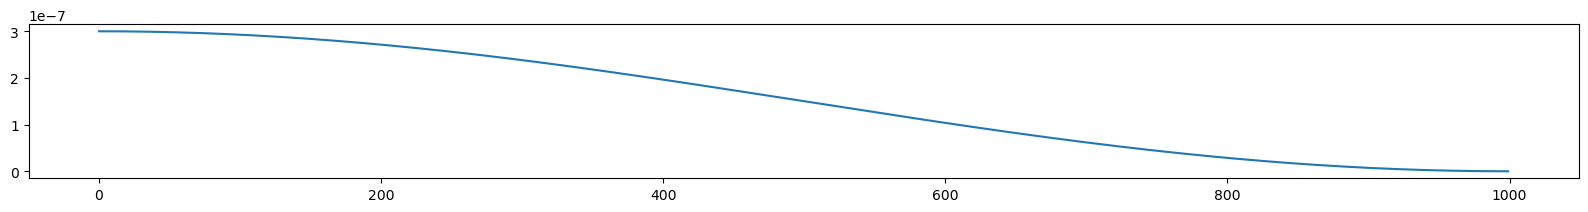

In [16]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [17]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = train_meta_df[train_meta_df['fold'] != fold].reset_index(drop=True)
    valid_ = train_meta_df[train_meta_df['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model.load_state_dict(torch.load(f'{BASE_PATH}/seg_models_backup/{kernel_type}_fold{fold}_best.pth'), strict=False)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 1000
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss, train_metric = train_func(model, loader_train, optimizer, scaler)
        metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, train metric: {train_metric:.5f}, val metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [18]:
run(0)
#run(1)
#run(2)
#run(3)
#run(4)

3782 929
Wed Aug 30 07:22:43 2023 Epoch: 1


  0%|          | 0/119 [00:00<?, ?it/s]/home/junseonglee/miniconda3/envs/rapids-23.06/lib/python3.10/site-packages/torch/nn/modules/conv.py:608: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(
smth:0.0000: 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]


Wed Aug 30 07:23:31 2023 Fold 0, Epoch 1, lr: 0.0000003, train loss: 19.37508, train metric: 4.70675, val metric: 3.517524.
metric_best (1000.000000 --> 3.517524). Saving model ...
Wed Aug 30 07:23:32 2023 Epoch: 2


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Wed Aug 30 07:24:15 2023 Fold 0, Epoch 2, lr: 0.0000003, train loss: 5.75692, train metric: 3.54554, val metric: 3.595051.
Wed Aug 30 07:24:15 2023 Epoch: 3


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


Wed Aug 30 07:24:59 2023 Fold 0, Epoch 3, lr: 0.0000003, train loss: 5.58603, train metric: 3.43380, val metric: 3.551836.
Wed Aug 30 07:24:59 2023 Epoch: 4


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Wed Aug 30 07:25:42 2023 Fold 0, Epoch 4, lr: 0.0000003, train loss: 5.55322, train metric: 3.42234, val metric: 3.735509.
Wed Aug 30 07:25:43 2023 Epoch: 5


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Wed Aug 30 07:26:26 2023 Fold 0, Epoch 5, lr: 0.0000003, train loss: 5.33300, train metric: 3.33453, val metric: 3.359959.
metric_best (3.517524 --> 3.359959). Saving model ...
Wed Aug 30 07:26:27 2023 Epoch: 6


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


Wed Aug 30 07:27:10 2023 Fold 0, Epoch 6, lr: 0.0000003, train loss: 5.30594, train metric: 3.29814, val metric: 3.390846.
Wed Aug 30 07:27:10 2023 Epoch: 7


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Wed Aug 30 07:27:54 2023 Fold 0, Epoch 7, lr: 0.0000003, train loss: 5.35346, train metric: 3.36995, val metric: 3.346247.
metric_best (3.359959 --> 3.346247). Saving model ...
Wed Aug 30 07:27:54 2023 Epoch: 8


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Wed Aug 30 07:28:38 2023 Fold 0, Epoch 8, lr: 0.0000003, train loss: 5.36056, train metric: 3.38191, val metric: 3.299431.
metric_best (3.346247 --> 3.299431). Saving model ...
Wed Aug 30 07:28:38 2023 Epoch: 9


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


Wed Aug 30 07:29:22 2023 Fold 0, Epoch 9, lr: 0.0000003, train loss: 5.31028, train metric: 3.23152, val metric: 4.038721.
Wed Aug 30 07:29:22 2023 Epoch: 10


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Wed Aug 30 07:30:05 2023 Fold 0, Epoch 10, lr: 0.0000003, train loss: 5.12463, train metric: 3.30180, val metric: 3.497918.
Wed Aug 30 07:30:06 2023 Epoch: 11


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Wed Aug 30 07:30:49 2023 Fold 0, Epoch 11, lr: 0.0000003, train loss: 4.74249, train metric: 3.11946, val metric: 3.372488.
Wed Aug 30 07:30:49 2023 Epoch: 12


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Wed Aug 30 07:31:33 2023 Fold 0, Epoch 12, lr: 0.0000003, train loss: 4.69412, train metric: 3.11060, val metric: 3.707591.
Wed Aug 30 07:31:33 2023 Epoch: 13


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Wed Aug 30 07:32:17 2023 Fold 0, Epoch 13, lr: 0.0000003, train loss: 4.67283, train metric: 3.07798, val metric: 3.249250.
metric_best (3.299431 --> 3.249250). Saving model ...
Wed Aug 30 07:32:17 2023 Epoch: 14


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


Wed Aug 30 07:33:00 2023 Fold 0, Epoch 14, lr: 0.0000003, train loss: 4.80468, train metric: 3.06383, val metric: 4.307066.
Wed Aug 30 07:33:01 2023 Epoch: 15


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


Wed Aug 30 07:33:44 2023 Fold 0, Epoch 15, lr: 0.0000003, train loss: 4.47436, train metric: 3.00915, val metric: 3.177448.
metric_best (3.249250 --> 3.177448). Saving model ...
Wed Aug 30 07:33:45 2023 Epoch: 16


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Wed Aug 30 07:34:28 2023 Fold 0, Epoch 16, lr: 0.0000003, train loss: 4.47409, train metric: 2.97768, val metric: 3.845631.
Wed Aug 30 07:34:29 2023 Epoch: 17


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Wed Aug 30 07:35:12 2023 Fold 0, Epoch 17, lr: 0.0000003, train loss: 4.47949, train metric: 2.97152, val metric: 3.244749.
Wed Aug 30 07:35:12 2023 Epoch: 18


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Wed Aug 30 07:35:56 2023 Fold 0, Epoch 18, lr: 0.0000003, train loss: 4.16579, train metric: 2.85024, val metric: 3.951353.
Wed Aug 30 07:35:56 2023 Epoch: 19


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


Wed Aug 30 07:36:39 2023 Fold 0, Epoch 19, lr: 0.0000003, train loss: 4.32145, train metric: 2.94311, val metric: 3.184222.
Wed Aug 30 07:36:40 2023 Epoch: 20


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Wed Aug 30 07:37:23 2023 Fold 0, Epoch 20, lr: 0.0000003, train loss: 4.10988, train metric: 2.78413, val metric: 3.293579.
Wed Aug 30 07:37:23 2023 Epoch: 21


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


Wed Aug 30 07:38:06 2023 Fold 0, Epoch 21, lr: 0.0000003, train loss: 4.26229, train metric: 2.86027, val metric: 3.161604.
metric_best (3.177448 --> 3.161604). Saving model ...
Wed Aug 30 07:38:07 2023 Epoch: 22


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


Wed Aug 30 07:38:50 2023 Fold 0, Epoch 22, lr: 0.0000003, train loss: 4.16840, train metric: 2.87506, val metric: 3.155327.
metric_best (3.161604 --> 3.155327). Saving model ...
Wed Aug 30 07:38:51 2023 Epoch: 23


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


Wed Aug 30 07:39:34 2023 Fold 0, Epoch 23, lr: 0.0000003, train loss: 3.97712, train metric: 2.75315, val metric: 3.302687.
Wed Aug 30 07:39:34 2023 Epoch: 24


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Wed Aug 30 07:40:18 2023 Fold 0, Epoch 24, lr: 0.0000003, train loss: 3.97012, train metric: 2.77218, val metric: 3.196732.
Wed Aug 30 07:40:18 2023 Epoch: 25


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Wed Aug 30 07:41:01 2023 Fold 0, Epoch 25, lr: 0.0000003, train loss: 3.89885, train metric: 2.72200, val metric: 3.071088.
metric_best (3.155327 --> 3.071088). Saving model ...
Wed Aug 30 07:41:02 2023 Epoch: 26


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Wed Aug 30 07:41:45 2023 Fold 0, Epoch 26, lr: 0.0000003, train loss: 3.85361, train metric: 2.71193, val metric: 3.328286.
Wed Aug 30 07:41:46 2023 Epoch: 27


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


Wed Aug 30 07:42:29 2023 Fold 0, Epoch 27, lr: 0.0000003, train loss: 3.87766, train metric: 2.73299, val metric: 3.310121.
Wed Aug 30 07:42:29 2023 Epoch: 28


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Wed Aug 30 07:43:13 2023 Fold 0, Epoch 28, lr: 0.0000003, train loss: 3.97495, train metric: 2.75712, val metric: 3.108060.
Wed Aug 30 07:43:13 2023 Epoch: 29


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Wed Aug 30 07:43:57 2023 Fold 0, Epoch 29, lr: 0.0000003, train loss: 3.54720, train metric: 2.52496, val metric: 3.255978.
Wed Aug 30 07:43:57 2023 Epoch: 30


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


Wed Aug 30 07:44:40 2023 Fold 0, Epoch 30, lr: 0.0000003, train loss: 3.62258, train metric: 2.61597, val metric: 3.286750.
Wed Aug 30 07:44:40 2023 Epoch: 31


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Wed Aug 30 07:45:24 2023 Fold 0, Epoch 31, lr: 0.0000003, train loss: 3.57837, train metric: 2.55384, val metric: 3.060784.
metric_best (3.071088 --> 3.060784). Saving model ...
Wed Aug 30 07:45:24 2023 Epoch: 32


smth:0.0000: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Wed Aug 30 07:46:08 2023 Fold 0, Epoch 32, lr: 0.0000003, train loss: 3.52622, train metric: 2.54457, val metric: 3.272269.
Wed Aug 30 07:46:08 2023 Epoch: 33


smth:5.2328:  50%|████▉     | 59/119 [00:19<00:17,  3.34it/s]

smth:2.8064:  50%|█████     | 60/119 [00:19<00:17,  3.34it/s]